In [1]:
import glob
import mido

NOTE_MAX = 119.0

def get_message_value(msg):
    if msg.type == "note_off" or msg.velocity == 0:
        return -msg.note / NOTE_MAX
    else:
        return msg.note / NOTE_MAX

def track_to_notes(track):
    return [get_message_value(m) for m in track if m.type.startswith("note_")]

def get_author_tracks(author):
    tracks = []
    for dr in glob.glob("dataset/" + author + "/**"):
        mid = mido.MidiFile(dr)
        tracks.extend(mid.tracks)
    return tracks

def get_author_note_list(author, min_note_count=600):
    tracks = get_author_tracks(author)
    note_list = [track_to_notes(t) for t in tracks]
    return [n for n in note_list if len(n) >= min_note_count]

def get_author_min_note_list(note_lists):
    lens = [len(t) for t in note_lists]
    return min(lens)

def divide_note_list_into_inputs(note_list, group_size=600):
    chunks = []
    chunk_size = len(note_list) // 600
    for i in range(0, chunk_size):
        chunks.append(note_list[group_size * i: group_size * (i + 1)])
    return chunks

def get_tracks_chunks(tracks):
    chunks = []
    for t in tracks:
        chunks.extend(divide_note_list_into_inputs(t))
    
    return chunks

albeniz_tracks = get_author_note_list("Albéniz Isaac")
chopin_tracks = get_author_note_list("Chopin")
# agnew_tracks = get_author_note_list("Agnew Roy")
# behr_tracks = get_author_note_list("Behr Franz")
liszt_tracks = get_author_note_list("Liszt Franz")
haydn_tracks = get_author_note_list("Haydn")
# zierau_tracks = get_author_note_list("Zierau Fritz")
# frontini_tracks = get_author_note_list("Frontini Francesco Paolo")

albeniz_chunks = get_tracks_chunks(albeniz_tracks)
chopin_chunks = get_tracks_chunks(chopin_tracks)
# agnew_chunks = get_tracks_chunks(agnew_tracks)
# behr_chunks = get_tracks_chunks(behr_tracks)
liszt_chunks = get_tracks_chunks(liszt_tracks)
haydn_chunks = get_tracks_chunks(haydn_tracks)
# zierau_chunks = get_tracks_chunks(zierau_tracks)
# frontini_chunks = get_tracks_chunks(frontini_tracks)

print("Albeniz Tracks: ", len(albeniz_tracks))
print("Chopin Tracks: ", len(chopin_tracks))
print("Liszt Tracks: ", len(liszt_tracks))
print("Haydn Tracks: ", len(haydn_tracks))

print("Albeniz Chunks: ", len(albeniz_chunks))
print("Chopin Chunks: ", len(chopin_chunks))
print("Liszt Chunks: ", len(liszt_chunks))
print("Haydn Chunks: ", len(haydn_chunks))

Albeniz Tracks:  6
Chopin Tracks:  99
Liszt Tracks:  6
Haydn Tracks:  64
Albeniz Chunks:  234
Chopin Chunks:  1747
Liszt Chunks:  221
Haydn Chunks:  1010


In [355]:
import numpy as np
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, LSTM, Conv1D, AveragePooling1D, Dense, Flatten, ZeroPadding1D, Reshape, GlobalAveragePooling1D, Dropout

def halve_array(arr):
    div = len(arr) // 2
    return arr[:div], arr[div:]

def create_labels(label, leng):
    labels = []
    for _ in range(leng):
        labels.append(label)
    return labels

def generate_data_from_chunks(i, chunks, label):
    if i == 0:
        cut_idx = int(0.3 * len(chunks))
        train, test = chunks[cut_idx:], chunks[:cut_idx]
        train_labels = create_labels(label, len(train))
        test_labels = create_labels(label, len(test))
    elif i == 1:
        f_idx = int(0.3 * len(chunks))
        s_idx = int(0.6 * len(chunks))
        test = []
        test.extend(chunks[:f_idx])
        test.extend(chunks[s_idx:])
        train = chunks[f_idx:s_idx]
        train_labels = create_labels(label, len(train))
        test_labels = create_labels(label, len(test))
    else:
        cut_idx = int(0.6 * len(chunks))
        train, test = chunks[:cut_idx], chunks[cut_idx:]
        train_labels = create_labels(label, len(train))
        test_labels = create_labels(label, len(test))

    return {
        "train_data": train,
        "test_data": test,
        "train_labels": train_labels,
        "test_labels": test_labels
    }

def train_data_from_datasets(datasets):
    data = []
    for d in datasets:
        data += d["train_data"]
    return np.array(data)

def train_labels_from_datasets(datasets):
    data = []
    for d in datasets:
        data += d["train_labels"] 
    return np.array(data)

input_dim = len(albeniz_chunks[0])

def test_data_from_datasets(datasets):
    data = []
    for d in datasets:
        data += d["test_data"]
    return np.array(data)

def test_labels_from_datasets(datasets):
    data = []
    for d in datasets:
        data += d["test_labels"]
    return np.array(data)

input_dim = len(albeniz_chunks[0])
histories = []
models = []

for i in range(3):
    albeniz_dataset = generate_data_from_chunks(i, albeniz_chunks[:100], [1.0, 0.0, 0.0, 0.0])
    # behr_dataset = generate_data_from_chunks(behr_chunks, [0.0, 1.0, 0.0, 0.0, 0.0, 0.0])
    # frontini_dataset = generate_data_from_chunks(frontini_chunks, [0.0, 0.0, 1.0, 0.0, 0.0, 0.0])
    liszt_dataset = generate_data_from_chunks(i, liszt_chunks[:100], [0.0, 1.0, 0.0, 0.0])
    haydn_dataset = generate_data_from_chunks(i, haydn_chunks[:100], [0.0, 0.0, 1.0, 0.0])
    chopin_dataset = generate_data_from_chunks(i, chopin_chunks[:100], [0.0, 0.0, 0.0, 1.0])
    # zierau_dataset = generate_data_from_chunks(zierau_chunks, [0.0, 0.0, 0.0, 0.0, 1.0, 0.0])
    # agnew_dataset = generate_data_from_chunks(agnew_chunks, [0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
    # datasets = [albeniz_dataset, behr_dataset, frontini_dataset, liszt_dataset, zierau_dataset, agnew_dataset]
    datasets = [albeniz_dataset, liszt_dataset, haydn_dataset, chopin_dataset]

    train_data = train_data_from_datasets(datasets)
    train_labels = train_labels_from_datasets(datasets)

    test_data = test_data_from_datasets(datasets)
    test_labels = test_labels_from_datasets(datasets)

    X, Y = shuffle(train_data, train_labels)
    TX, TY = shuffle(test_data, test_labels)

    model = Sequential([
        Reshape((600, 1), input_shape=(input_dim, )),
        Conv1D(42, 32, activation="relu", input_shape=((600, 1))),
        AveragePooling1D(),
        Conv1D(32, 32, activation="relu"),
        AveragePooling1D(),
        Conv1D(32, 32, activation="relu"),
        AveragePooling1D(),
        Dropout(0.45),
        Flatten(),
        Dense(4, activation="softmax")
    ])
    model.summary()

    opt = keras.optimizers.Adam(learning_rate=0.000016)
    model.compile(
      optimizer=opt,
      loss="categorical_crossentropy",
      metrics=[categorical_accuracy],
    )

    history = model.fit(
        X,
        Y,
        validation_data=(TX, TY),
        epochs=160
    )
    models.append(model)
    histories.append(history)

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_95 (Reshape)         (None, 600, 1)            0         
_________________________________________________________________
conv1d_253 (Conv1D)          (None, 569, 42)           1386      
_________________________________________________________________
average_pooling1d_194 (Avera (None, 284, 42)           0         
_________________________________________________________________
conv1d_254 (Conv1D)          (None, 253, 32)           43040     
_________________________________________________________________
average_pooling1d_195 (Avera (None, 126, 32)           0         
_________________________________________________________________
conv1d_255 (Conv1D)          (None, 95, 32)            32800     
_________________________________________________________________
average_pooling1d_196 (Avera (None, 47, 32)          

9/9 [==============================] - 0s 41ms/step - loss: 1.3652 - categorical_accuracy: 0.3522 - val_loss: 1.3835 - val_categorical_accuracy: 0.2167
Epoch 41/160
9/9 [==============================] - 0s 42ms/step - loss: 1.3653 - categorical_accuracy: 0.3146 - val_loss: 1.3831 - val_categorical_accuracy: 0.2417
Epoch 42/160
9/9 [==============================] - 0s 41ms/step - loss: 1.3548 - categorical_accuracy: 0.4025 - val_loss: 1.3829 - val_categorical_accuracy: 0.2583
Epoch 43/160
9/9 [==============================] - 0s 42ms/step - loss: 1.3626 - categorical_accuracy: 0.3786 - val_loss: 1.3826 - val_categorical_accuracy: 0.2167
Epoch 44/160
9/9 [==============================] - 0s 41ms/step - loss: 1.3536 - categorical_accuracy: 0.4061 - val_loss: 1.3822 - val_categorical_accuracy: 0.2083
Epoch 45/160
9/9 [==============================] - 0s 41ms/step - loss: 1.3518 - categorical_accuracy: 0.4275 - val_loss: 1.3818 - val_categorical_accuracy: 0.2083
Epoch 46/160
9/9 [=====

Epoch 90/160
9/9 [==============================] - 0s 41ms/step - loss: 1.2079 - categorical_accuracy: 0.5726 - val_loss: 1.2819 - val_categorical_accuracy: 0.4333
Epoch 91/160
9/9 [==============================] - 0s 41ms/step - loss: 1.1942 - categorical_accuracy: 0.5472 - val_loss: 1.2789 - val_categorical_accuracy: 0.4250
Epoch 92/160
9/9 [==============================] - 0s 41ms/step - loss: 1.1864 - categorical_accuracy: 0.5687 - val_loss: 1.2706 - val_categorical_accuracy: 0.4417
Epoch 93/160
9/9 [==============================] - 0s 41ms/step - loss: 1.1850 - categorical_accuracy: 0.5404 - val_loss: 1.2702 - val_categorical_accuracy: 0.4250
Epoch 94/160
9/9 [==============================] - 0s 40ms/step - loss: 1.1556 - categorical_accuracy: 0.5713 - val_loss: 1.2590 - val_categorical_accuracy: 0.4667
Epoch 95/160
9/9 [==============================] - 0s 41ms/step - loss: 1.1738 - categorical_accuracy: 0.5197 - val_loss: 1.2536 - val_categorical_accuracy: 0.4500
Epoch 96/1

9/9 [==============================] - 0s 41ms/step - loss: 0.9389 - categorical_accuracy: 0.5984 - val_loss: 1.1301 - val_categorical_accuracy: 0.4417
Epoch 140/160
9/9 [==============================] - 0s 41ms/step - loss: 0.9560 - categorical_accuracy: 0.5978 - val_loss: 1.1287 - val_categorical_accuracy: 0.4500
Epoch 141/160
9/9 [==============================] - 0s 41ms/step - loss: 0.9630 - categorical_accuracy: 0.6192 - val_loss: 1.1291 - val_categorical_accuracy: 0.4500
Epoch 142/160
9/9 [==============================] - 0s 40ms/step - loss: 1.0140 - categorical_accuracy: 0.5421 - val_loss: 1.1318 - val_categorical_accuracy: 0.4417
Epoch 143/160
9/9 [==============================] - 0s 40ms/step - loss: 1.0173 - categorical_accuracy: 0.5581 - val_loss: 1.1369 - val_categorical_accuracy: 0.4250
Epoch 144/160
9/9 [==============================] - 0s 41ms/step - loss: 0.9618 - categorical_accuracy: 0.6320 - val_loss: 1.1319 - val_categorical_accuracy: 0.4417
Epoch 145/160
9/9 

4/4 [==============================] - 0s 54ms/step - loss: 1.3889 - categorical_accuracy: 0.2698 - val_loss: 1.3873 - val_categorical_accuracy: 0.2214
Epoch 19/160
4/4 [==============================] - 0s 53ms/step - loss: 1.3786 - categorical_accuracy: 0.3306 - val_loss: 1.3873 - val_categorical_accuracy: 0.2214
Epoch 20/160
4/4 [==============================] - 0s 53ms/step - loss: 1.3806 - categorical_accuracy: 0.3006 - val_loss: 1.3872 - val_categorical_accuracy: 0.2179
Epoch 21/160
4/4 [==============================] - 0s 53ms/step - loss: 1.3762 - categorical_accuracy: 0.3525 - val_loss: 1.3872 - val_categorical_accuracy: 0.2179
Epoch 22/160
4/4 [==============================] - 0s 53ms/step - loss: 1.3805 - categorical_accuracy: 0.3535 - val_loss: 1.3872 - val_categorical_accuracy: 0.2179
Epoch 23/160
4/4 [==============================] - 0s 53ms/step - loss: 1.3765 - categorical_accuracy: 0.3479 - val_loss: 1.3872 - val_categorical_accuracy: 0.2214
Epoch 24/160
4/4 [=====

Epoch 68/160
4/4 [==============================] - 0s 53ms/step - loss: 1.3626 - categorical_accuracy: 0.3410 - val_loss: 1.3849 - val_categorical_accuracy: 0.2429
Epoch 69/160
4/4 [==============================] - 0s 54ms/step - loss: 1.3536 - categorical_accuracy: 0.4579 - val_loss: 1.3849 - val_categorical_accuracy: 0.2536
Epoch 70/160
4/4 [==============================] - 0s 54ms/step - loss: 1.3582 - categorical_accuracy: 0.4156 - val_loss: 1.3848 - val_categorical_accuracy: 0.2536
Epoch 71/160
4/4 [==============================] - 0s 53ms/step - loss: 1.3558 - categorical_accuracy: 0.4179 - val_loss: 1.3848 - val_categorical_accuracy: 0.2536
Epoch 72/160
4/4 [==============================] - 0s 53ms/step - loss: 1.3507 - categorical_accuracy: 0.5223 - val_loss: 1.3847 - val_categorical_accuracy: 0.2500
Epoch 73/160
4/4 [==============================] - 0s 53ms/step - loss: 1.3645 - categorical_accuracy: 0.3975 - val_loss: 1.3847 - val_categorical_accuracy: 0.2464
Epoch 74/1

4/4 [==============================] - 0s 56ms/step - loss: 1.3321 - categorical_accuracy: 0.5010 - val_loss: 1.3797 - val_categorical_accuracy: 0.2643
Epoch 118/160
4/4 [==============================] - 0s 53ms/step - loss: 1.3246 - categorical_accuracy: 0.4685 - val_loss: 1.3794 - val_categorical_accuracy: 0.2679
Epoch 119/160
4/4 [==============================] - 0s 53ms/step - loss: 1.3255 - categorical_accuracy: 0.4377 - val_loss: 1.3791 - val_categorical_accuracy: 0.2714
Epoch 120/160
4/4 [==============================] - 0s 53ms/step - loss: 1.3186 - categorical_accuracy: 0.4796 - val_loss: 1.3787 - val_categorical_accuracy: 0.2821
Epoch 121/160
4/4 [==============================] - 0s 55ms/step - loss: 1.3115 - categorical_accuracy: 0.5392 - val_loss: 1.3783 - val_categorical_accuracy: 0.2964
Epoch 122/160
4/4 [==============================] - 0s 54ms/step - loss: 1.3041 - categorical_accuracy: 0.6240 - val_loss: 1.3780 - val_categorical_accuracy: 0.2929
Epoch 123/160
4/4 

8/8 [==============================] - 1s 79ms/step - loss: 1.3869 - categorical_accuracy: 0.2058 - val_loss: 1.3865 - val_categorical_accuracy: 0.2875
Epoch 2/160
8/8 [==============================] - 0s 40ms/step - loss: 1.3888 - categorical_accuracy: 0.2849 - val_loss: 1.3859 - val_categorical_accuracy: 0.2625
Epoch 3/160
8/8 [==============================] - 0s 40ms/step - loss: 1.3855 - categorical_accuracy: 0.2277 - val_loss: 1.3855 - val_categorical_accuracy: 0.2812
Epoch 4/160
8/8 [==============================] - 0s 40ms/step - loss: 1.3910 - categorical_accuracy: 0.2246 - val_loss: 1.3852 - val_categorical_accuracy: 0.2750
Epoch 5/160
8/8 [==============================] - 0s 40ms/step - loss: 1.3928 - categorical_accuracy: 0.2166 - val_loss: 1.3850 - val_categorical_accuracy: 0.2875
Epoch 6/160
8/8 [==============================] - 0s 40ms/step - loss: 1.3844 - categorical_accuracy: 0.2802 - val_loss: 1.3847 - val_categorical_accuracy: 0.2812
Epoch 7/160
8/8 [===========

Epoch 51/160
8/8 [==============================] - 0s 40ms/step - loss: 1.3328 - categorical_accuracy: 0.4575 - val_loss: 1.3587 - val_categorical_accuracy: 0.3250
Epoch 52/160
8/8 [==============================] - 0s 40ms/step - loss: 1.3394 - categorical_accuracy: 0.4608 - val_loss: 1.3571 - val_categorical_accuracy: 0.3438
Epoch 53/160
8/8 [==============================] - 0s 40ms/step - loss: 1.3336 - categorical_accuracy: 0.4252 - val_loss: 1.3555 - val_categorical_accuracy: 0.4000
Epoch 54/160
8/8 [==============================] - 0s 40ms/step - loss: 1.3249 - categorical_accuracy: 0.5295 - val_loss: 1.3538 - val_categorical_accuracy: 0.3875
Epoch 55/160
8/8 [==============================] - 0s 40ms/step - loss: 1.3247 - categorical_accuracy: 0.4839 - val_loss: 1.3522 - val_categorical_accuracy: 0.3562
Epoch 56/160
8/8 [==============================] - 0s 40ms/step - loss: 1.3308 - categorical_accuracy: 0.4946 - val_loss: 1.3502 - val_categorical_accuracy: 0.3938
Epoch 57/1

Epoch 101/160
8/8 [==============================] - 0s 40ms/step - loss: 1.1430 - categorical_accuracy: 0.5209 - val_loss: 1.1852 - val_categorical_accuracy: 0.4750
Epoch 102/160
8/8 [==============================] - 0s 40ms/step - loss: 1.1482 - categorical_accuracy: 0.4954 - val_loss: 1.1801 - val_categorical_accuracy: 0.4500
Epoch 103/160
8/8 [==============================] - 0s 40ms/step - loss: 1.0886 - categorical_accuracy: 0.5667 - val_loss: 1.1769 - val_categorical_accuracy: 0.4563
Epoch 104/160
8/8 [==============================] - 0s 40ms/step - loss: 1.1109 - categorical_accuracy: 0.5510 - val_loss: 1.1728 - val_categorical_accuracy: 0.4500
Epoch 105/160
8/8 [==============================] - 0s 39ms/step - loss: 1.0918 - categorical_accuracy: 0.5378 - val_loss: 1.1743 - val_categorical_accuracy: 0.5063
Epoch 106/160
8/8 [==============================] - 0s 40ms/step - loss: 1.0981 - categorical_accuracy: 0.5135 - val_loss: 1.1705 - val_categorical_accuracy: 0.4812
Epoc

8/8 [==============================] - 0s 40ms/step - loss: 0.9984 - categorical_accuracy: 0.5353 - val_loss: 1.1341 - val_categorical_accuracy: 0.4563
Epoch 151/160
8/8 [==============================] - 0s 40ms/step - loss: 0.9656 - categorical_accuracy: 0.5653 - val_loss: 1.1333 - val_categorical_accuracy: 0.4437
Epoch 152/160
8/8 [==============================] - 0s 40ms/step - loss: 0.9435 - categorical_accuracy: 0.6242 - val_loss: 1.1339 - val_categorical_accuracy: 0.4375
Epoch 153/160
8/8 [==============================] - 0s 40ms/step - loss: 0.9855 - categorical_accuracy: 0.6308 - val_loss: 1.1334 - val_categorical_accuracy: 0.4437
Epoch 154/160
8/8 [==============================] - 0s 40ms/step - loss: 0.9283 - categorical_accuracy: 0.6033 - val_loss: 1.1356 - val_categorical_accuracy: 0.4563
Epoch 155/160
8/8 [==============================] - 0s 40ms/step - loss: 0.9471 - categorical_accuracy: 0.6253 - val_loss: 1.1323 - val_categorical_accuracy: 0.4375
Epoch 156/160
8/8 

In [356]:
loss = (np.array(histories[0].history["loss"]) + np.array(histories[1].history["loss"]) + np.array(histories[2].history["loss"])) / 3
acc = (np.array(histories[0].history["categorical_accuracy"]) + np.array(histories[1].history["categorical_accuracy"]) + np.array(histories[2].history["categorical_accuracy"])) / 3
val_loss = (np.array(histories[0].history["val_loss"]) + np.array(histories[1].history["val_loss"]) + np.array(histories[2].history["val_loss"])) / 3
val_acc = (np.array(histories[0].history["val_categorical_accuracy"]) + np.array(histories[1].history["val_categorical_accuracy"]) + np.array(histories[2].history["val_categorical_accuracy"])) / 3


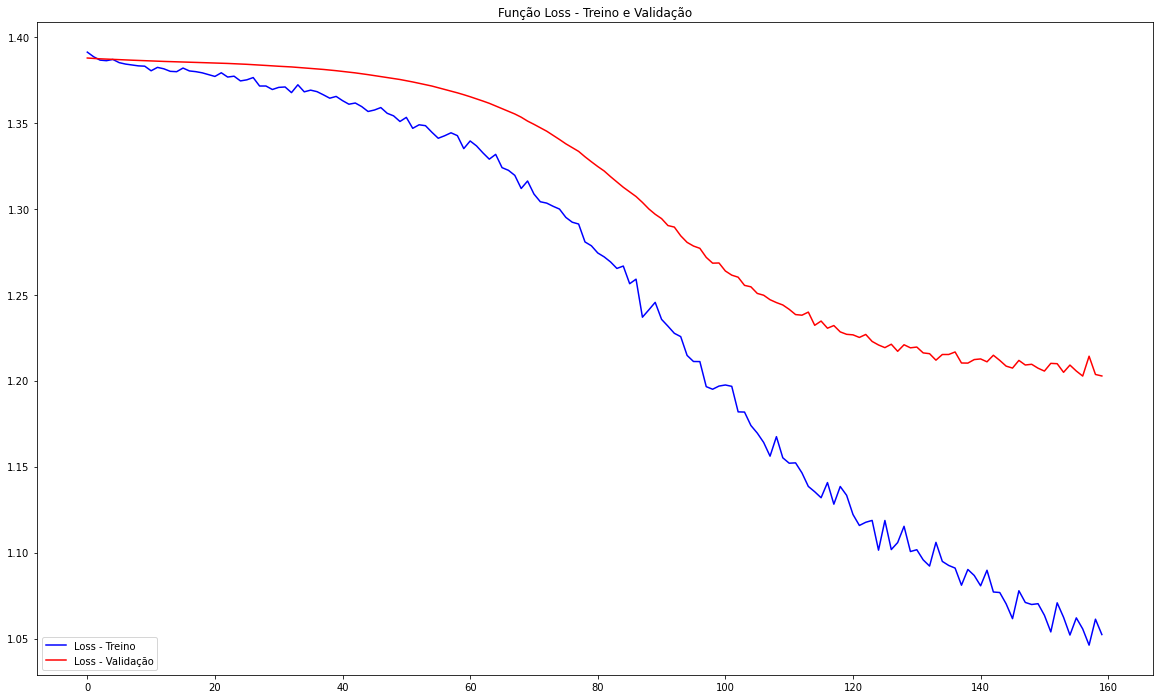

In [357]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 12]

plt.title("Função Loss - Treino e Validação")

plt.plot(loss, "b", label="Loss - Treino")
plt.plot(val_loss, "r", label="Loss - Validação")
_ = plt.legend(loc="lower left")

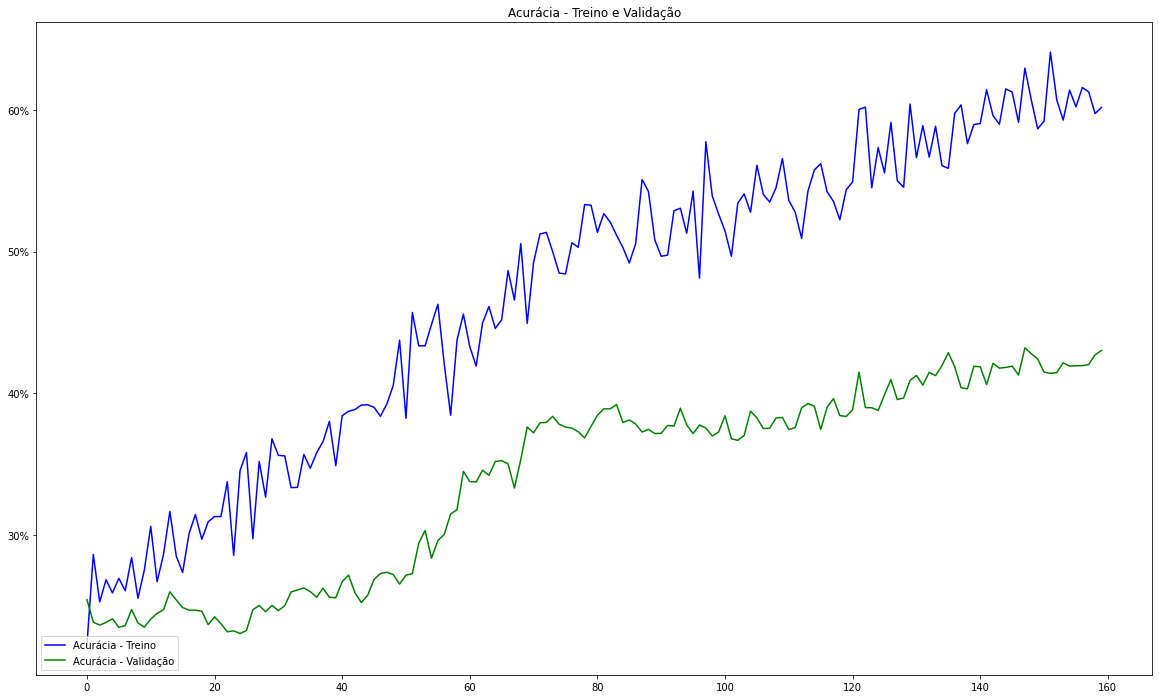

In [358]:
from matplotlib.ticker import FuncFormatter

axes = plt.gca()
axes.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))


plt.title("Acurácia - Treino e Validação")
plt.plot(acc, "b", label="Acurácia - Treino")
plt.plot(val_acc, "g", label="Acurácia - Validação")
_ = plt.legend(loc="lower left")

In [364]:
from sklearn import metrics
import seaborn as sn
import pandas as pd

pred = (models[0].predict(TX) + models[1].predict(TX) + models[2].predict(TX)) / 3.0
pred_int = [np.argmax(p) for p in pred]
final_int = [np.argmax(p) for p in TY]
cf = metrics.confusion_matrix(final_int, pred_int, normalize="all")

# albeniz_dataset, behr_dataset, frontini_dataset, liszt_dataset, zierau_dataset, agnew_dataset
# True na vertical
authors = ["Albeniz", "Liszt", "Haydn", "Chopin"]
df = pd.DataFrame(cf, index=authors, columns=authors)
df.applymap(lambda d: '{:.1f} %'.format(400.0 * d))

[0.13024579 0.38666138 0.06582021 0.41727266] [0.10921955 0.5409046  0.0032335  0.34664235]


,Albeniz,Liszt,Haydn,Chopin
Albeniz,40.0 %,10.0 %,20.0 %,30.0 %
Liszt,10.0 %,40.0 %,12.5 %,37.5 %
Haydn,5.0 %,0.0 %,95.0 %,0.0 %
Chopin,12.5 %,20.0 %,10.0 %,57.5 %


In [360]:
print(metrics.classification_report(final_int, pred_int, target_names=authors))

print("ROC AUC: ", metrics.roc_auc_score(TY, pred, multi_class="ovr", labels=authors))

              precision    recall  f1-score   support

     Albeniz       0.59      0.40      0.48        40
       Liszt       0.57      0.40      0.47        40
       Haydn       0.69      0.95      0.80        40
      Chopin       0.46      0.57      0.51        40

    accuracy                           0.58       160
   macro avg       0.58      0.58      0.56       160
weighted avg       0.58      0.58      0.56       160

ROC AUC:  0.81359375
